In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('/kaggle/input/ail-weather-forecast/weatherAUS.csv')
print(df.head())
print("-"*70)
print(df.describe())
print("-"*70)
print("The size of the dataframe is:",df.shape)

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

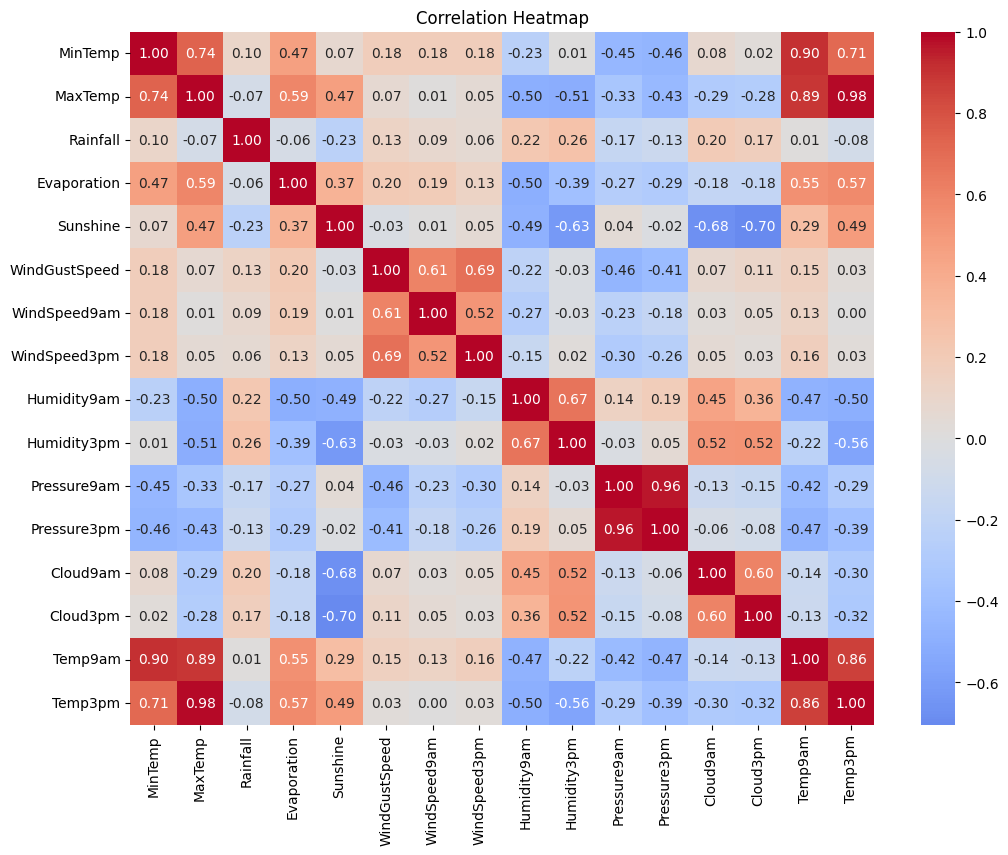

In [3]:
# Correlation for numeric features
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12,9))
corr = df[numeric_columns].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,        
    fmt=".2f",         
    annot_kws={"size": 10}  
)

plt.title("Correlation Heatmap")
plt.show()

--- 

In [4]:
df_missing = df.isnull().sum()
perc_missing = round(100 * df_missing / len(df), 2)

print(df_missing)
print("-" * 25)
print(perc_missing)

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64
-------------------------
Date              0.00
Location          0.00
MinTemp           1.02
MaxTemp           0.87
Rainfall          2.24
Evaporation      43.17
Sunshine         48.01
WindGustDir       7.10
WindGustSpeed     7.06
WindDir9am        7.26
WindDir3pm        2.91
WindSpeed9am      1.21
WindSpeed3pm      2.11
Humidity9am       1.82
Humidity3pm       3.10
Pressure9am      10.36
Pressure3pm      10.33
Cloud9am         38.42
Cloud3pm         4

In [5]:
# dropping columns with large % of missing values - also dropping RISK_MM based on instructions in the description
df = df.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm'], axis=1)

# change date type to datetime
df['Date'] = pd.to_datetime(df['Date'])

print(df.head())
print("-"*70)
print("The new size of the dataframe is:", df.shape)
print("We deleted",df.shape[0]-df.shape[0],"rows and", df.shape[1]-df.shape[1],"columns.")
df.dtypes

        Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0 2008-12-01   Albury     13.4     22.9       0.6           W           44.0   
1 2008-12-02   Albury      7.4     25.1       0.0         WNW           44.0   
2 2008-12-03   Albury     12.9     25.7       0.0         WSW           46.0   
3 2008-12-04   Albury      9.2     28.0       0.0          NE           24.0   
4 2008-12-05   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Tem

Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Temp9am                 float64
Temp3pm                 float64
RainToday                object
RainTomorrow             object
dtype: object

--- 

Text(0.5, 1.0, 'Rainfall throughout the Years')

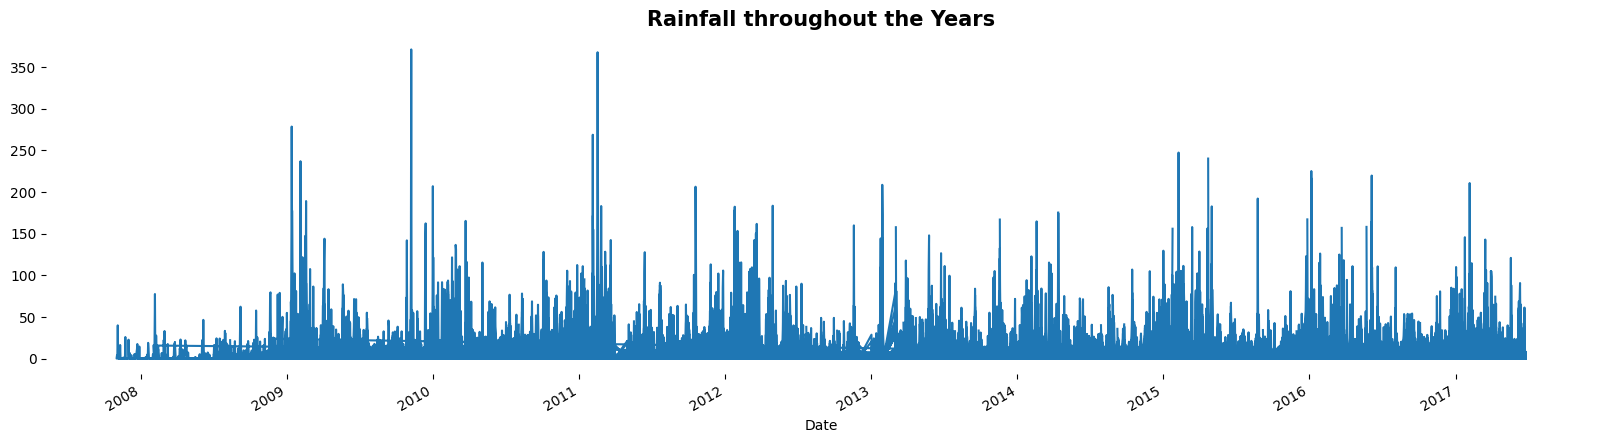

In [6]:
#set day as index
df.set_index('Date', inplace=True)

# Plotting rainfall during time
plt.figure(figsize=(20,5))
df['Rainfall'].plot()
plt.box(False)
plt.title ('Rainfall throughout the Years',fontweight="bold", fontsize=15)

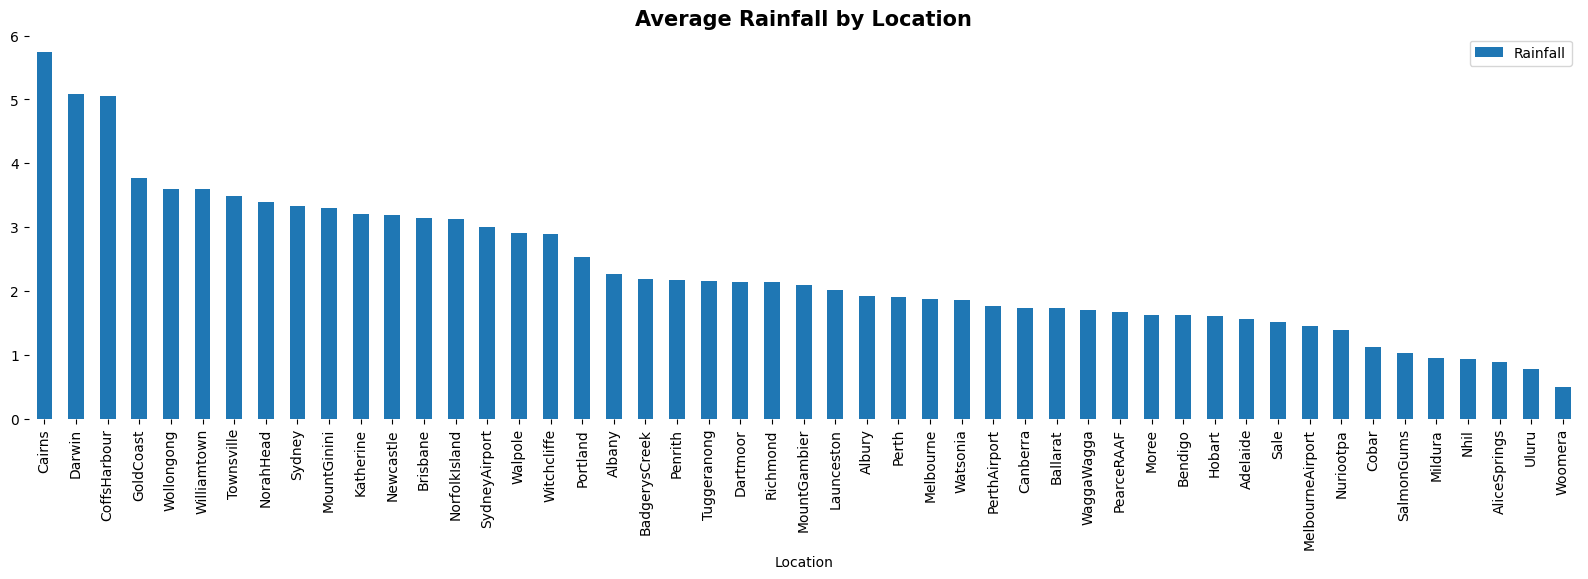

In [7]:
# plotting average Rainfall by Location
df_loc = df.groupby('Location').agg({'Rainfall':'mean'}).sort_values(by='Rainfall', ascending=False) 

df_loc.plot(kind='bar',figsize=(20,5))
plt.box(False)
plt.title ('Average Rainfall by Location', fontsize=15, fontweight="bold")
plt.show()

In [8]:
df['Rainfall_log'] = np.log1p(df['Rainfall'])

# Drop raw
df = df.drop(columns=['Rainfall', 'RainToday','RainTomorrow'], errors='ignore')

In [9]:
df.head()

,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Rainfall_log
Date,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.470004
2008-12-02,Albury,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.000000
2008-12-03,Albury,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.000000
2008-12-04,Albury,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.000000
2008-12-05,Albury,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.693147


=> Xử lí bằng model chứ không tác động vào data

---

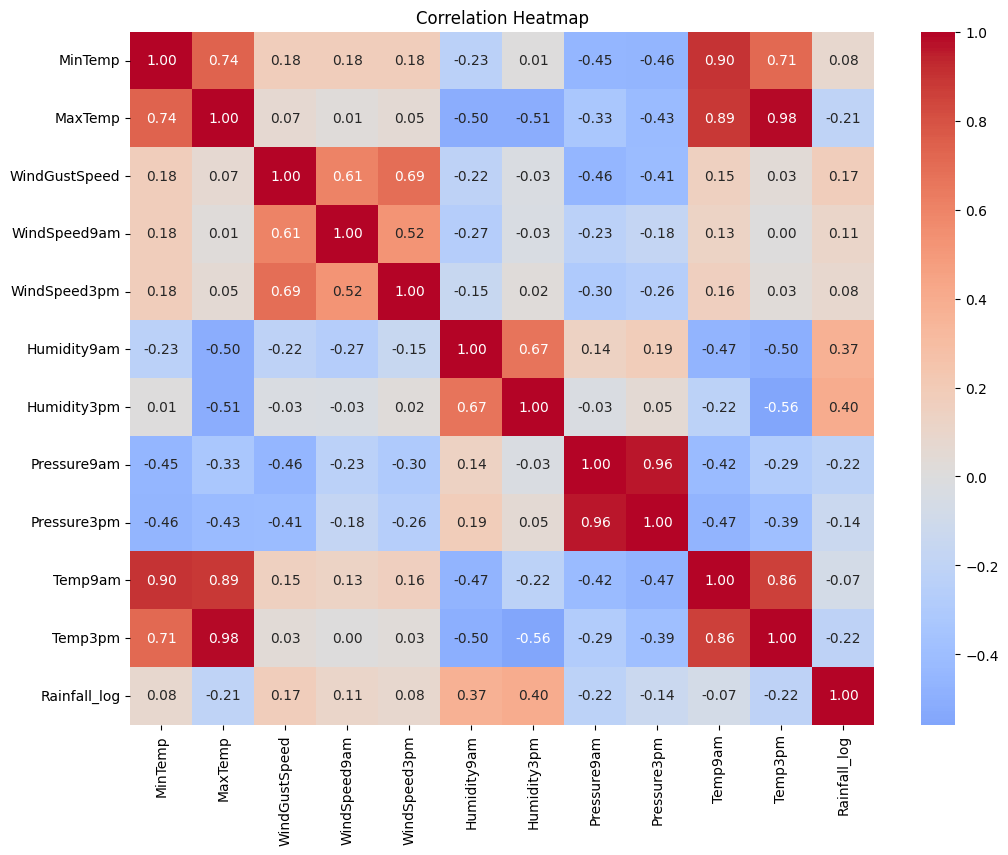

In [10]:
# Correlation for numeric features
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12,9))
corr = df[numeric_columns].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,        
    fmt=".2f",         
    annot_kws={"size": 10}  
)

plt.title("Correlation Heatmap")
plt.show()

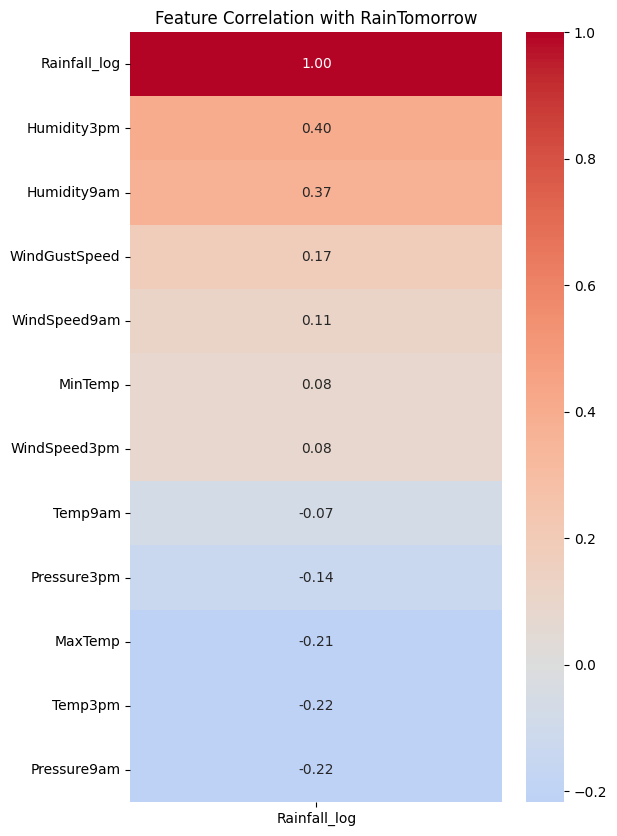

In [11]:
target = "Rainfall_log"

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

corr_target = (
    df[numeric_columns]
    .corr()[target]
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,10))
sns.heatmap(
    corr_target.to_frame(),
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Feature Correlation with RainTomorrow")
plt.show()

In [12]:
# print(corr_target)

In [13]:
df.head()

,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Rainfall_log
Date,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.470004
2008-12-02,Albury,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.000000
2008-12-03,Albury,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.000000
2008-12-04,Albury,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.000000
2008-12-05,Albury,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.693147


In [14]:
df.shape

(145460, 16)

--- 

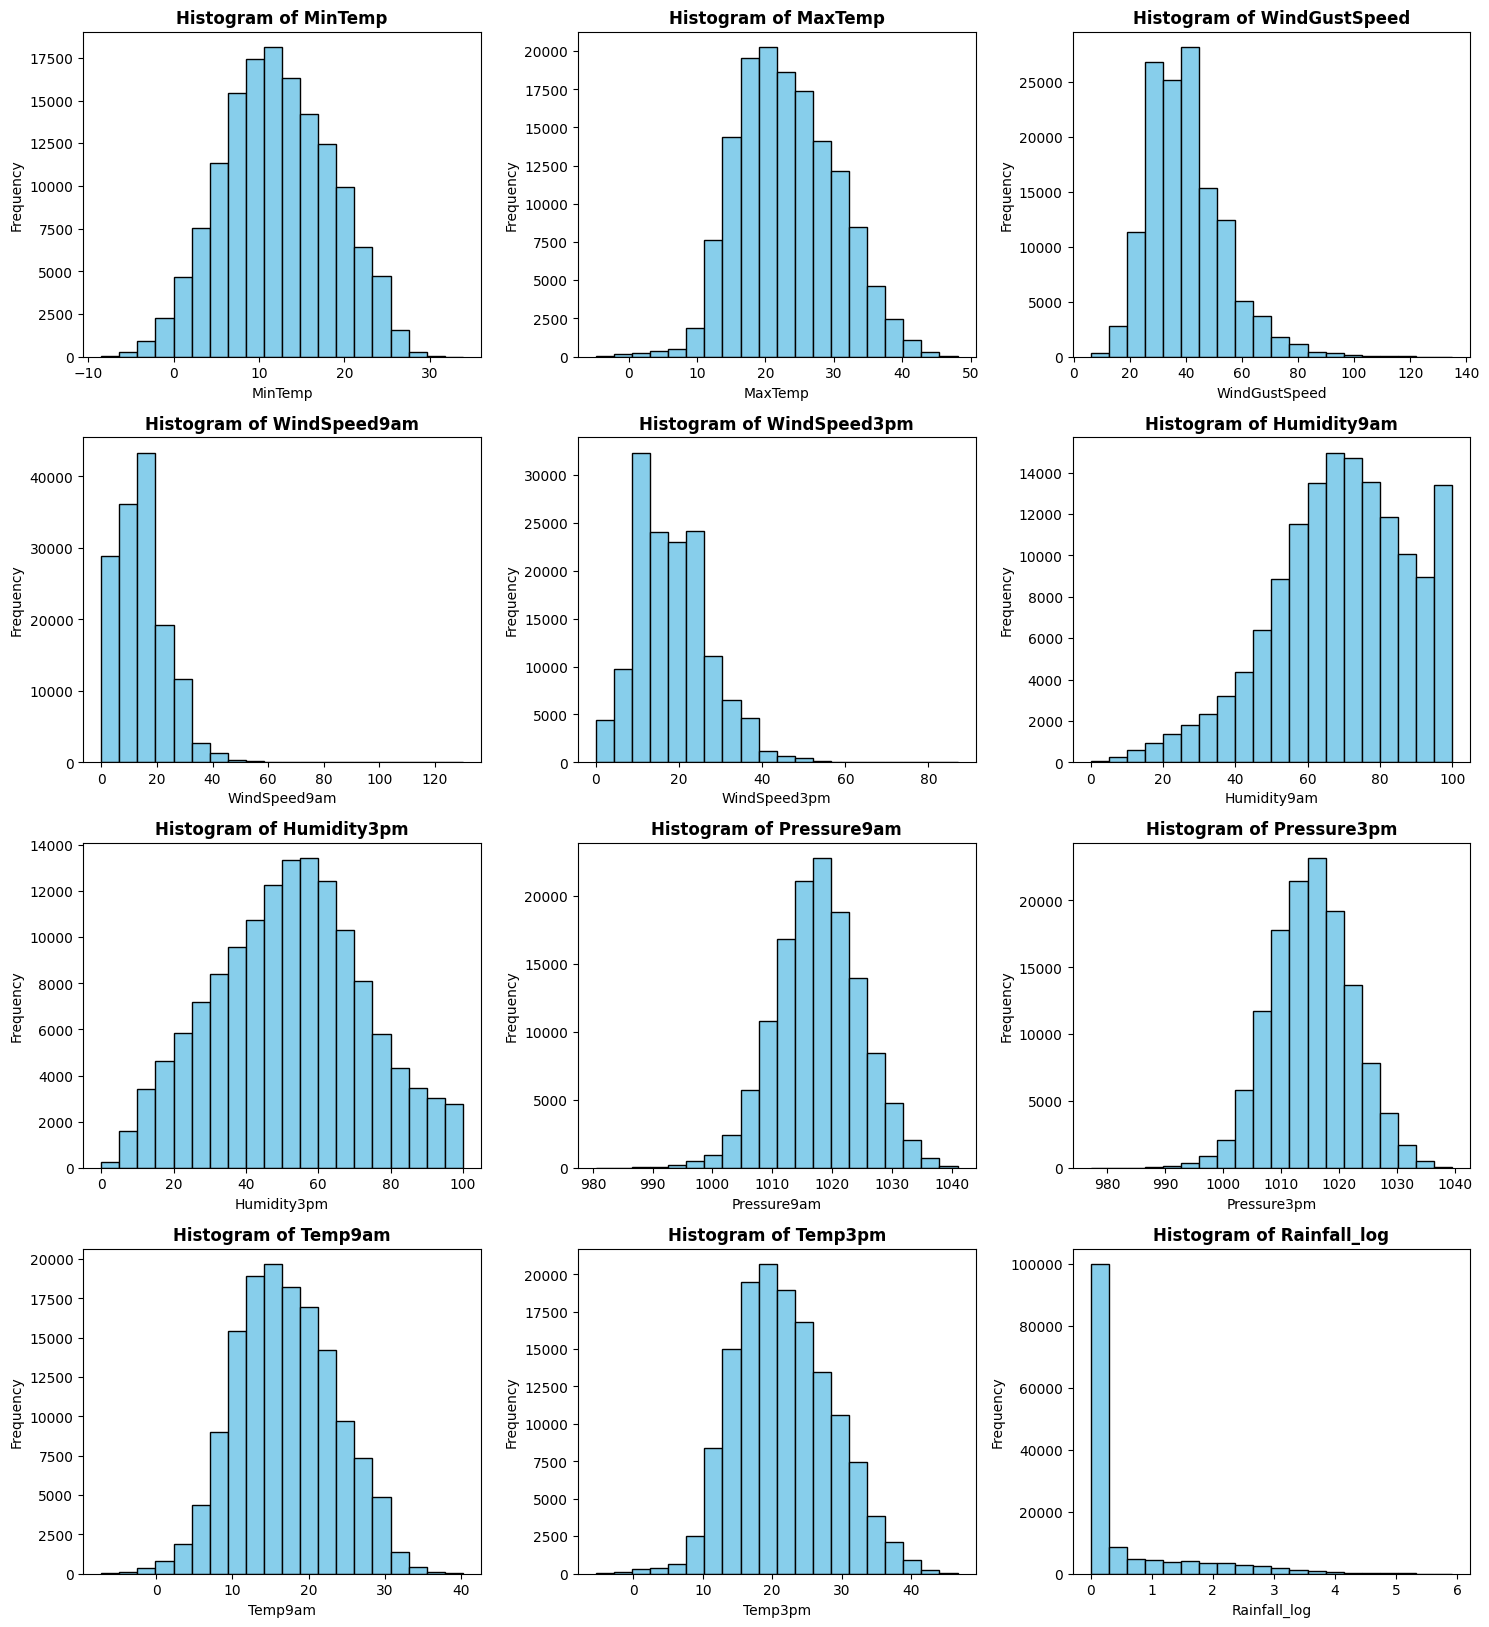

In [15]:
# Create histograms for each numeric column
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    plt.hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Histogram of {col}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ***Preprocessing***

In [16]:
df = df.reset_index()


In [17]:
df.head(n=10)

,Date,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Rainfall_log
0,2008-12-01,Albury,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.470004
1,2008-12-02,Albury,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.000000
2,2008-12-03,Albury,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.000000
3,2008-12-04,Albury,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.000000
4,2008-12-05,Albury,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.693147
5,2008-12-06,Albury,14.6,29.7,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,20.6,28.9,0.182322
6,2008-12-07,Albury,14.3,25.0,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,18.1,24.6,0.000000
7,2008-12-08,Albury,7.7,26.7,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,16.3,25.5,0.000000
8,2008-12-09,Albury,9.7,31.9,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,18.3,30.2,0.000000
9,2008-12-10,Albury,13.1,30.1,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,20.1,28.2,0.875469


In [18]:
 df.shape

(145460, 17)

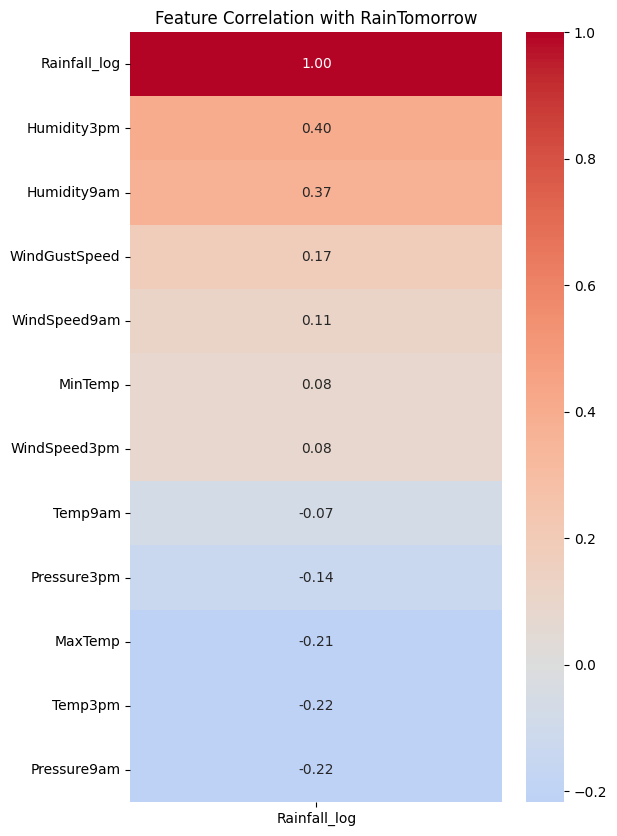

In [19]:
target = "Rainfall_log"

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

corr_target = (
    df[numeric_columns]
    .corr()[target]
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,10))
sns.heatmap(
    corr_target.to_frame(),
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Feature Correlation with RainTomorrow")
plt.show()

In [20]:
wind_map = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

wind_cols = ["WindGustDir", "WindDir9am", "WindDir3pm"]

for col in wind_cols:
    df[col] = df[col].map(wind_map)
    # df[col] = df[col].fillna("UNK")  # hoặc "Missing"

for col in wind_cols:
    df[col + "_sin"] = np.sin(np.deg2rad(df[col]))
    df[col + "_cos"] = np.cos(np.deg2rad(df[col]))

df.drop(wind_cols, axis=1, inplace=True)

# df.drop("Location", axis=1, inplace=True)

# dont scale binary
# binary_cols = [
#     "HighHumidity3pm",
#     "LowPressure3pm"
# ]

In [21]:
df.head()

,Date,Location,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Rainfall_log,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos
0,2008-12-01,Albury,13.4,22.9,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.470004,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,-0.923880,3.826834e-01
1,2008-12-02,Albury,7.4,25.1,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.000000,-0.923880,3.826834e-01,-0.382683,9.238795e-01,-0.923880,-3.826834e-01
2,2008-12-03,Albury,12.9,25.7,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.000000,-0.923880,-3.826834e-01,-1.000000,-1.836970e-16,-0.923880,-3.826834e-01
3,2008-12-04,Albury,9.2,28.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.000000,0.707107,7.071068e-01,0.707107,-7.071068e-01,1.000000,6.123234e-17
4,2008-12-05,Albury,17.5,32.3,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.693147,-1.000000,-1.836970e-16,0.923880,3.826834e-01,-0.707107,7.071068e-01


In [22]:
# check for null values
df_missing = df.isnull().sum()
df_missing

Date                   0
Location               0
MinTemp             1485
MaxTemp             1261
WindGustSpeed      10263
WindSpeed9am        1767
WindSpeed3pm        3062
Humidity9am         2654
Humidity3pm         4507
Pressure9am        15065
Pressure3pm        15028
Temp9am             1767
Temp3pm             3609
Rainfall_log        3261
WindGustDir_sin    10326
WindGustDir_cos    10326
WindDir9am_sin     10566
WindDir9am_cos     10566
WindDir3pm_sin      4228
WindDir3pm_cos      4228
dtype: int64

In [23]:
df.dtypes

Date               datetime64[ns]
Location                   object
MinTemp                   float64
MaxTemp                   float64
WindGustSpeed             float64
WindSpeed9am              float64
WindSpeed3pm              float64
Humidity9am               float64
Humidity3pm               float64
Pressure9am               float64
Pressure3pm               float64
Temp9am                   float64
Temp3pm                   float64
Rainfall_log              float64
WindGustDir_sin           float64
WindGustDir_cos           float64
WindDir9am_sin            float64
WindDir9am_cos            float64
WindDir3pm_sin            float64
WindDir3pm_cos            float64
dtype: object

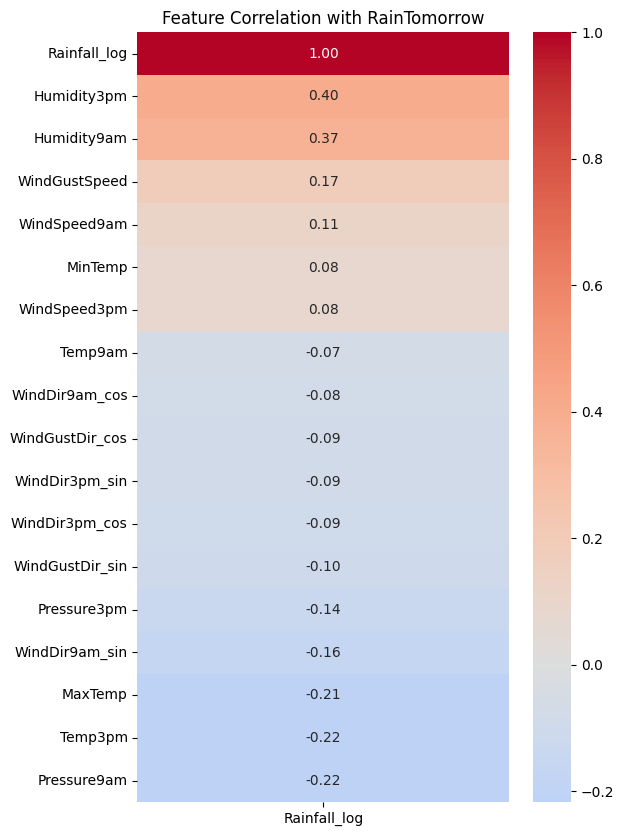

In [24]:
target = "Rainfall_log"

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

corr_target = (
    df[numeric_columns]
    .corr()[target]
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,10))
sns.heatmap(
    corr_target.to_frame(),
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Feature Correlation with RainTomorrow")
plt.show()

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# ===== 1. Load & parse Date =====
df['Date'] = pd.to_datetime(df['Date'])

# Tạo các đặc trưng thời gian
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.dayofweek
df['season'] = df['month'] % 12 // 3  # 0: winter, 1: spring, ...

# ===== 2. Encode Location bằng OneHot =====
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
location_encoded = encoder.fit_transform(df[['Location']])
location_df = pd.DataFrame(location_encoded, 
                           columns=encoder.get_feature_names_out(['Location']),
                           index=df.index)

df = pd.concat([df, location_df], axis=1)

# ===== 3. Xử lý missing =====
def impute_group(g):
    g = g.sort_values('Date')  # đảm bảo theo thời gian
    
    # interpolate cho missing ngắn (<=2 ngày)
    g = g.interpolate(limit=2, limit_direction='both')
    
    # rolling mean cho missing dài hơn (<=30 ngày) chỉ áp dụng cho numeric
    numeric_cols = g.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        g[col] = g[col].fillna(g[col].rolling(30, min_periods=1).mean())
    
    # xử lý gap quá dài: nếu khoảng cách giữa 2 ngày > 365 thì coi như chuỗi bị đứt
    g['gap'] = g['Date'].diff().dt.days
    g = g[g['gap'].fillna(1) <= 365]  # drop các đoạn cách xa > 1 năm
    
    g = g.drop(columns=['gap'])
    return g

df = df.groupby('Location', group_keys=False).apply(impute_group).reset_index(drop=True)

# ===== Bổ sung xử lý missing cho các biến gió =====
wind_cols = ["WindGustSpeed", "WindGustDir_sin", "WindGustDir_cos"]

def impute_wind(group):
    group = group.sort_values("Date")

    # 1. Interpolate cho missing ngắn (<=2 ngày)
    group[wind_cols] = group[wind_cols].interpolate(limit=2, limit_direction="both")

    # 2. Rolling mean cho missing dài hơn (7 ngày)
    for col in wind_cols:
        group[col] = group[col].fillna(group[col].rolling(7, min_periods=1).mean())

    # 3. Fill theo trung bình tháng trong từng Location
    group[wind_cols] = group.groupby(group["Date"].dt.month)[wind_cols].transform(
        lambda x: x.fillna(x.mean())
    )

    # 4. Fill theo median toàn Location (bước cuối cùng để chắc chắn không còn NaN)
    group[wind_cols] = group[wind_cols].fillna(group[wind_cols].median())

    return group

# Áp dụng theo từng Location
df = df.groupby("Location", group_keys=False).apply(impute_wind).reset_index(drop=True)
# Fill cuối cùng bằng median toàn dataset (nếu vẫn còn NaN) 
df[wind_cols] = df[wind_cols].fillna(df[wind_cols].median())

# Kiểm tra lại missing sau khi fill
print(df[wind_cols].isna().sum())


# ===== 4. Tạo lag features =====
lag_features = [
    'MinTemp','MaxTemp','Rainfall_log',
    'Humidity9am','Humidity3pm',
    'Pressure9am','Pressure3pm',
    'Temp9am','Temp3pm'
]

for col in lag_features:
    for lag in [1,3,7]:
        df[f'{col}_lag{lag}'] = df.groupby('Location')[col].shift(lag)

# ===== 5. Drop dòng thiếu lag =====
df = df.dropna(subset=[f'{col}_lag{lag}' for col in lag_features for lag in [1,3,7]])

# ===== 6. Ready for ML =====
feature_cols = (
    ['year','month','day','day_of_week','season'] +
    lag_features +
    [f'{col}_lag{lag}' for col in lag_features for lag in [1,3,7]] +
    list(location_df.columns)  # thêm các cột one-hot Location
)
X = df[feature_cols]
y = df['Rainfall_log']

print("Final dataset shape:", X.shape, y.shape)

WindGustSpeed      0
WindGustDir_sin    0
WindGustDir_cos    0
dtype: int64
Final dataset shape: (128925, 90) (128925,)


In [26]:
df.head()

,Date,Location,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,Pressure9am_lag7,Pressure3pm_lag1,Pressure3pm_lag3,Pressure3pm_lag7,Temp9am_lag1,Temp9am_lag3,Temp9am_lag7,Temp3pm_lag1,Temp3pm_lag3,Temp3pm_lag7
7,2008-12-08,Albury,7.7,26.7,35.0,6.0,17.0,48.0,19.0,1013.4,...,1007.7,1008.2,1006.0,1007.1,18.1,17.8,16.9,24.6,29.7,21.8
8,2008-12-09,Albury,9.7,31.9,80.0,7.0,28.0,42.0,9.0,1008.9,...,1010.6,1010.1,1005.4,1007.8,16.3,20.6,17.2,25.5,28.9,24.3
9,2008-12-10,Albury,13.1,30.1,28.0,15.0,11.0,58.0,27.0,1007.0,...,1007.6,1003.6,1008.2,1008.7,18.3,18.1,21.0,30.2,24.6,23.2
10,2008-12-11,Albury,13.4,30.4,30.0,17.0,6.0,48.0,22.0,1011.8,...,1017.6,1005.7,1010.1,1012.8,20.1,16.3,18.1,28.2,25.5,26.5
11,2008-12-12,Albury,15.9,21.7,31.0,15.0,13.0,89.0,91.0,1010.5,...,1010.8,1008.7,1003.6,1006.0,20.4,18.3,17.8,28.8,30.2,29.7


In [27]:
missing = df.isnull().sum()
missing = missing[missing > 0]

missing_percent = missing / len(df) * 100

pd.DataFrame({
    "missing_count": missing,
    "missing_percent (%)": missing_percent
})

,missing_count,missing_percent (%)
MaxTemp,1,0.000776
WindSpeed9am,2,0.001551
WindSpeed3pm,3,0.002327
Humidity9am,3,0.002327
Humidity3pm,6,0.004654
Pressure9am,4,0.003103
Pressure3pm,6,0.004654
Temp3pm,3,0.002327
Rainfall_log,1,0.000776
WindDir9am_sin,2,0.001551


In [28]:
# ===== 5b. Đảm bảo không còn NaN =====
# Drop các dòng thiếu target
df = df.dropna(subset=["Rainfall_log"])

# Fill toàn bộ numeric còn thiếu bằng median theo Location
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df.groupby("Location")[num_cols].transform(lambda x: x.fillna(x.median()))

# Nếu vẫn còn NaN (ví dụ ở đầu/đuôi chuỗi), fill bằng median toàn dataset
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Assert check: báo lỗi nếu vẫn còn NaN
missing_summary = df.isna().sum()
if missing_summary.sum() > 0:
    print("⚠️ Vẫn còn missing sau xử lý:")
    print(missing_summary[missing_summary > 0])
else:
    print("✅ Không còn missing, dữ liệu sạch sẵn sàng cho ML")

✅ Không còn missing, dữ liệu sạch sẵn sàng cho ML


In [29]:
missing = df.isnull().sum()
missing = missing[missing > 0]

missing_percent = missing / len(df) * 100

pd.DataFrame({
    "missing_count": missing,
    "missing_percent (%)": missing_percent
})

,missing_count,missing_percent (%)


## ***Train***

In [30]:
def split_by_location(df, target="Rainfall_log", train_ratio=0.7, val_ratio=0.15):
    """
    Chia train/val/test theo time series cho từng Location.
    """
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list, y_test_list = [], []

    for loc, g in df.groupby("Location"):
        g = g.sort_values("Date").reset_index(drop=True)

        # X, y
        y = g[target]
        X = g.drop(columns=[target, "Date", "Location"])

        # split index
        n = len(g)
        split_train = int(n * train_ratio)
        split_val = int(n * (train_ratio + val_ratio))

        # train
        X_train_list.append(X.iloc[:split_train])
        y_train_list.append(y.iloc[:split_train])

        # val
        X_val_list.append(X.iloc[split_train:split_val])
        y_val_list.append(y.iloc[split_train:split_val])

        # test
        X_test_list.append(X.iloc[split_val:])
        y_test_list.append(y.iloc[split_val:])

    # ghép lại tất cả location
    X_train = pd.concat(X_train_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    X_val   = pd.concat(X_val_list).reset_index(drop=True)
    y_val   = pd.concat(y_val_list).reset_index(drop=True)
    X_test  = pd.concat(X_test_list).reset_index(drop=True)
    y_test  = pd.concat(y_test_list).reset_index(drop=True)

    return X_train, y_train, X_val, y_val, X_test, y_test


# ===============================
# Gọi hàm chia dữ liệu
# ===============================
X_train, y_train, X_val, y_val, X_test, y_test = split_by_location(df)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)



Train: (90231, 98) (90231,)
Val: (19337, 98) (19337,)
Test: (19356, 98) (19356,)


In [31]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, tree_method="hist", eval_metric="rmse"
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=800, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
}
print("Loading model.... done!")

Loading model.... done!


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {
        "model": name,
        "mse": round(mse, 4),
        "rmse": round(rmse, 4),
        "mae": round(mae, 4),
        "r2": round(r2, 4),
        "y_pred": y_pred
    }

    return metrics


In [33]:
results = []
for name, pipe in models.items():
    print(f"\n▶ Training {name} ...")
    pipe.fit(X_train, y_train)

    # --- Train ---
    r_train = evaluate_model(name, pipe, X_train, y_train)
    print(f"   {name} - Train: RMSE={r_train['rmse']:.4f}, MAE={r_train['mae']:.4f}, R2={r_train['r2']:.4f}")
    results.append({**r_train, "set":"train"})

    # --- Validation ---
    r_val = evaluate_model(name, pipe, X_val, y_val)
    print(f"   {name} - Val  : RMSE={r_val['rmse']:.4f}, MAE={r_val['mae']:.4f}, R2={r_val['r2']:.4f}")
    results.append({**r_val, "set":"val"})

    # --- Test ---
    r_test = evaluate_model(name, pipe, X_test, y_test)
    print(f"   {name} - Test : RMSE={r_test['rmse']:.4f}, MAE={r_test['mae']:.4f}, R2={r_test['r2']:.4f}")
    results.append({**r_test, "set":"test"})

# Tổng hợp kết quả
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["model","set"]).reset_index(drop=True)

print("\n📊 Tổng hợp kết quả:")
print(results_df)



▶ Training RandomForest ...
   RandomForest - Train: RMSE=0.2110, MAE=0.1275, R2=0.9460
   RandomForest - Val  : RMSE=0.5986, MAE=0.3755, R2=0.5421
   RandomForest - Test : RMSE=0.6153, MAE=0.4032, R2=0.5478

▶ Training XGBoost ...
   XGBoost - Train: RMSE=0.4355, MAE=0.2670, R2=0.7700
   XGBoost - Val  : RMSE=0.5582, MAE=0.3392, R2=0.6017
   XGBoost - Test : RMSE=0.5777, MAE=0.3709, R2=0.6015

▶ Training LightGBM ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9950
[LightGBM] [Info] Number of data points in the train set: 90231, number of used features: 94
[LightGBM] [Info] Start training from score 0.494393
   LightGBM - Train: RMSE=0.4373, MAE=0.2665, R2=0.7681
   LightGBM - Val  : RMSE=0.5574, MAE=0.3319, R2=0.6030
   LightGBM - Test : RMSE=0.5735, MAE=0.3590, R2=0.6073

📊 Tổng hợp kết quả:
          model     mse    rmse     mae      r